In [1]:
import pandas as pd 
import numpy as np 
import sklearn
import matplotlib.pyplot as plt
import utilities

In [2]:
# Import train and test
train = pd.read_csv("../../datatmp/data/application_train.csv")
test = pd.read_csv("../../datatmp/data/application_test.csv")

In [3]:
# Exploration Basics
print(train.shape)
test.shape

(307511, 122)


(48744, 121)

In [4]:
# Balaceness of the train set
nodef= train[train['TARGET']==0]
print(str(len(nodef)/307511))

0.9192711805431351


In [5]:
## NULL VALUES ##

nulls= train.isnull().sum()
nulls= nulls[nulls > 0]

#how many null values are present per feature?
(nulls / train.shape[0]).sort_values(ascending=False)

COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
                              ...   
EXT_SOURCE_2                0.002146
AMT_GOODS_PRICE             0.000904
AMT_ANNUITY                 0.000039
CNT_FAM_MEMBERS             0.000007
DAYS_LAST_PHONE_CHANGE      0.000003
Length: 67, dtype: float64

/home/arbiterelegantiae/anaconda3/envs/homedefaul/lib/python3.7/site-packages/missingno/missingno.py:198: UserWarning: The 'inline' argument has been deprecated, and will be removed in a future version of missingno.
  "The 'inline' argument has been deprecated, and will be removed in a future version "


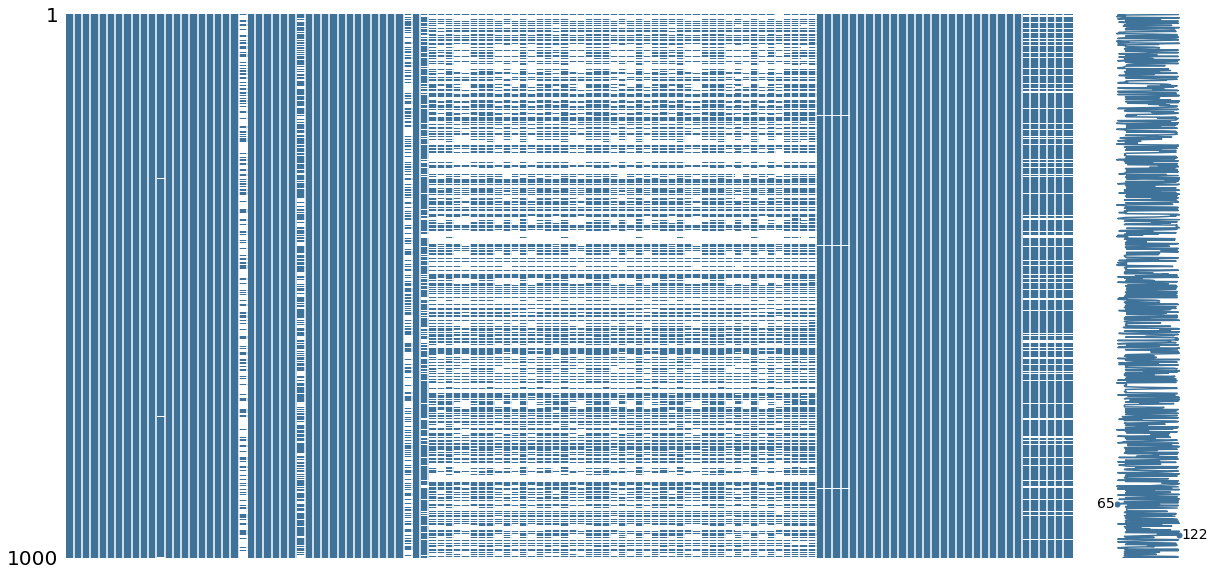

In [6]:
# Quite a lot!
# As suggested in https://www.kaggle.com/jpmiller/patterns-of-missing-data 
# Missing data can be meaningful for prediction 
# Use missingno package to discover possible correlations between nan in different features 
import missingno as msno

# Use a sample of 1000 records 
msno.matrix(train.sample(1000), inline=True, sparkline=True, figsize=(20,10), sort=None, color=(0.25, 0.45, 0.6))

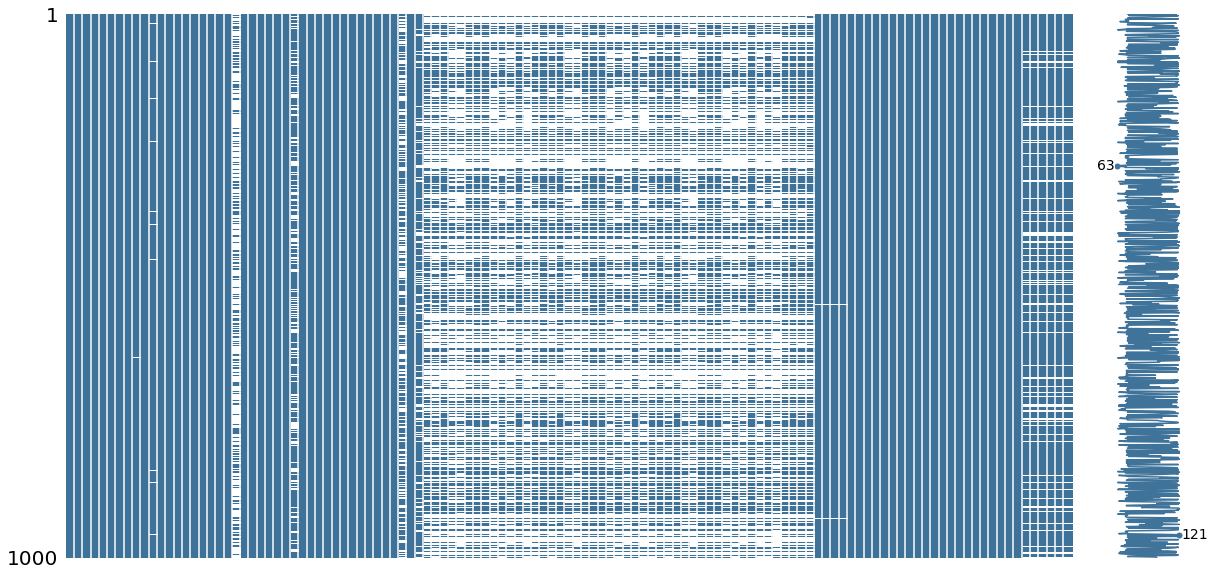

In [7]:
# Does the test follow the same trend?
msno.matrix(test.sample(1000), inline=True, sparkline=True, figsize=(20,10), sort=None, color=(0.25, 0.45, 0.6))

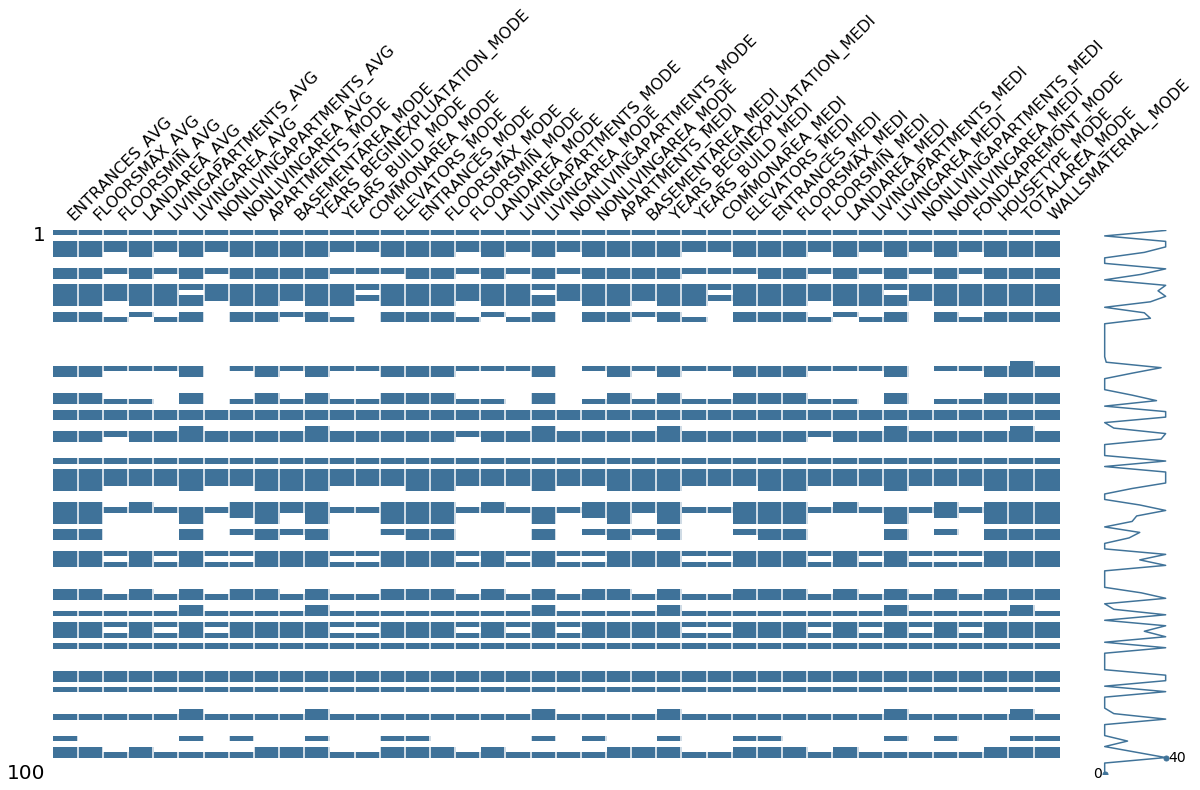

In [8]:
# It seems that most of the missing values are found within central features, due to the high dimension of features we need to narrow our analysis in that area (columns ~ [40:100]) to discover which features are causing this behaviour
msno.matrix(train.iloc[:,50:90].sample(100), inline=True, sparkline=True, figsize=(20,10), sort=None, color=(0.25, 0.45, 0.6))

In [9]:
# It looks like most of these features are related to accomodation's info. In particular almost half of the clients didnt provide such info.
# It comes then natural to ask if there is a correlation between lack of provided accomodation data and default's ratio
train['incomplete'] = 1
train.loc[train.iloc[:,40:100].isnull().sum(axis=1) <= 30, 'incomplete'] = 0 #those who provided most accomodation info

# Compute correlations with the target by computing percentage of default
accDefault = np.mean(train.loc[train['incomplete'] == 0, 'TARGET'].values)
naccDefault = np.mean(train.loc[train['incomplete'] == 1, 'TARGET'].values)
print('default ratio for more complete: {:.1%} \ndefault ratio for less complete: {:.1%}'.format(accDefault, naccDefault))

default ratio for more complete: 7.0% 
default ratio for less complete: 9.2%


In [10]:
test['incomplete'] = 1
test.loc[test.iloc[:,40:100].isnull().sum(axis=1) <= 30, 'incomplete'] = 0

In [11]:
# Indeed the ratio highlights a possible positive correlation which is encoded in a new feature 'incomplete' hopefully useful for generalization

In [12]:
# Since we have encoded the "meaning" of missing values we can now remove more-than-half empty columns which have few data since they will not be very informative (heuristic)
train = utilities.remove_missing_columns(train, 60)

There are 17 columns with greater than 60% missing values.


In [13]:
## ONE HOT ENCODING ##

In [14]:
train.dtypes
#shows a lot of categorical features which we want to transform into numerical features
#binary categorical -> 0,1 
#what about more catoegories? Giving more values ie 0,1,2,3,... would make the model attribute them different importances whereas they are just different cateogries! Thus replace them with different features one for each category

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
incomplete                      int64
Length: 106, dtype: object

In [15]:
# identify and print all the categorical columns
for col in train.columns:
    if train[col].dtype == object:
        print(col)
        print(train[col].unique())

NAME_CONTRACT_TYPE
['Cash loans' 'Revolving loans']
CODE_GENDER
['M' 'F' 'XNA']
FLAG_OWN_CAR
['N' 'Y']
FLAG_OWN_REALTY
['Y' 'N']
NAME_TYPE_SUITE
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers

In [16]:
from sklearn.preprocessing import LabelEncoder

def onehot_binenc(df):

    le = sklearn.preprocessing.LabelEncoder()
    #find feaures w two categories and transform them either to 0 or 1
    for col in df.columns:
        if df[col].dtype == object and len(df[col].unique()) <= 2 :
            le.fit(df[col])
            df[col]=le.transform(df[col])
    #one hot encoding of the remaining k-categorical features, w/ k>2
    return pd.get_dummies(df)
        

In [17]:
train = onehot_binenc(train)
test = onehot_binenc(test)

In [18]:
train.shape

(307511, 224)

In [19]:
test.shape
#We remain w/ more columns in the testset. This is due to the fact that we did not removed missing columns here and also because of differents sets of unique values in categorical variables. Thus align the two sets

(48744, 239)

In [20]:
#We need the same set of columns in both train and test set
target = train['TARGET']

#Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

#Add the target back in
train['TARGET'] = target

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 219)
Testing Features shape:  (48744, 218)


In [21]:
# As for the previous cell, there a bunch of features with missing values, then we want to substitute those missing values with a certain strategy, e.g. by replacing w/ the median 

from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

imputer.fit(train)
train.loc[:] = imputer.transform(train)

imputer.fit(test)
test.loc[:] = imputer.transform(test)


In [22]:
#check for null values
nulls= train.isnull().sum()
nulls= nulls[nulls > 0]

#how many null values are now present?
nulls.shape

(0,)

Plots for DAYS_BIRTH                                         


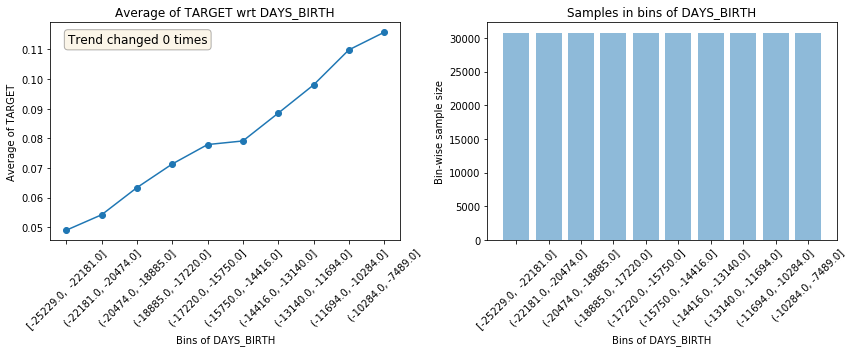

--------------------------------------------------------------------------------------------------------------




In [23]:
## Noisy and bugged features ##

from featexp import get_univariate_plots

# Plots drawn for all features if nothing is passed in feature_list parameter.
get_univariate_plots(data=train, target_col='TARGET', 
                     features_list=['DAYS_BIRTH'], bins=10)
# RESULT: The more they are young, the more the tend not to pay!

In [24]:
# Build a validation set
msk = np.random.rand(len(train)) < 0.75
trainset = train[msk].astype(np.float32)
validationset = train[~msk].astype(np.float32)

Plots for DAYS_EMPLOYED                                        
                                           Train data plots                                           


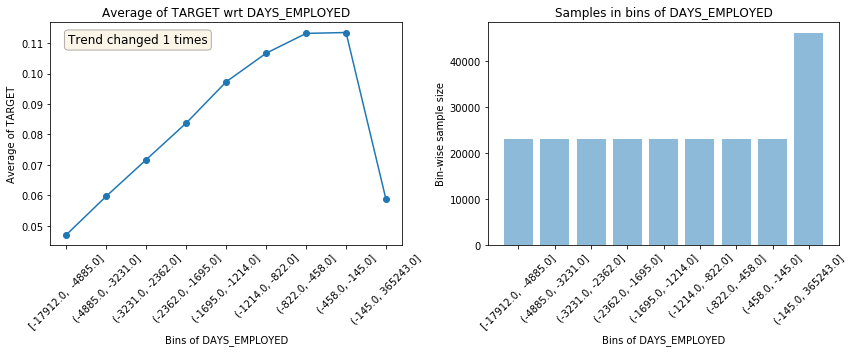

Test data plots                                            


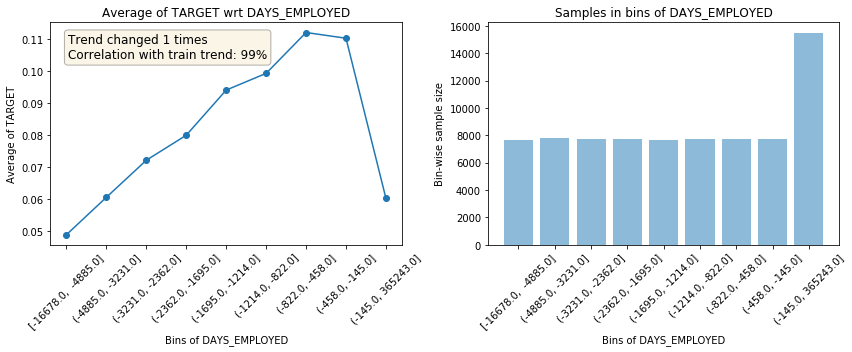

--------------------------------------------------------------------------------------------------------------




In [25]:
get_univariate_plots(data=trainset, target_col='TARGET', data_test=validationset, features_list=['DAYS_EMPLOYED'], bins=10)

#RESULT: High correlation between the trend in validation and train set, therefore should not be a noisy feature!
# What if the trend changes a lot tho? Well it might be true then that this its a symptom of noisyness nevertheless the considered bins migh differ a lot in other features giving us a different trends in default rates.
# What should we do then? Cross Validation!

In [26]:
# First get stats for every feature
from featexp import get_trend_stats
stats = get_trend_stats(data=trainset, target_col='TARGET', data_test=validationset)

Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Only one bin created for FLAG_DOCUMENT_12. Correlation can't be calculated
Returning stats for all numeric features


Plots for FLAG_MOBIL                                         


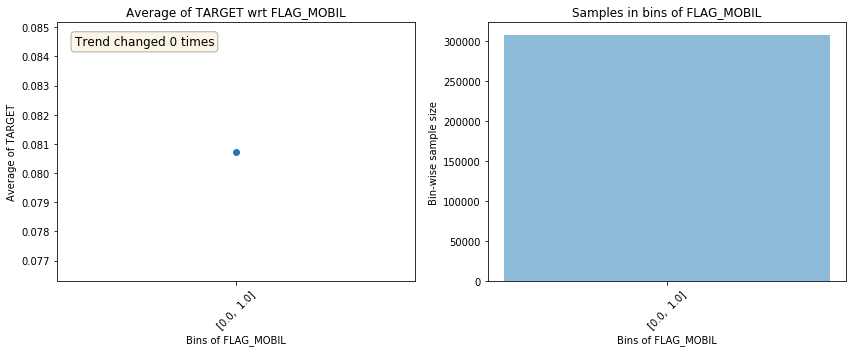

--------------------------------------------------------------------------------------------------------------


                                      Plots for FLAG_CONT_MOBILE                                      


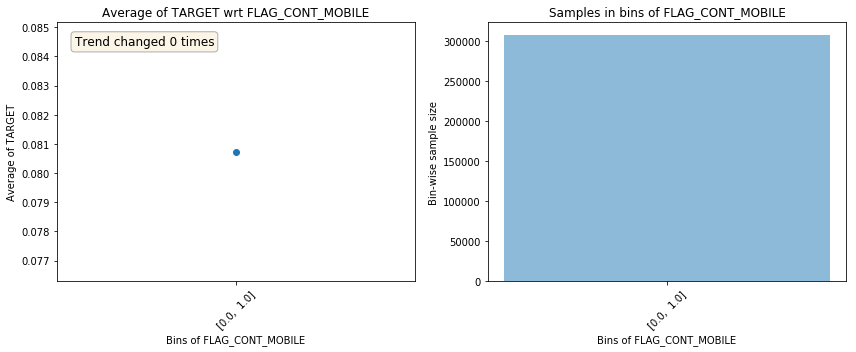

--------------------------------------------------------------------------------------------------------------


                                      Plots for FLAG_DOCUMENT_12                                      


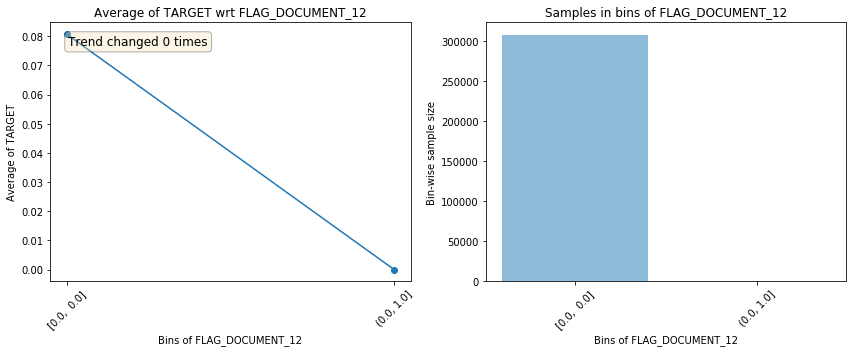

--------------------------------------------------------------------------------------------------------------




In [27]:
# For some features, featexp couldnt compute the correlation
get_univariate_plots(data=train, target_col='TARGET', 
                     features_list=['FLAG_MOBIL','FLAG_CONT_MOBILE','FLAG_DOCUMENT_12'], bins=20)


In [28]:
# As the plots show these are binary features so unbalanced that only one bin was computed
# This means that the variance is so low that this features can be considered as constant features hence irrelevant. They will be deleted in the following cells

In [29]:
stats

,Feature,Trend_changes,Trend_changes_test,Trend_correlation
0,SK_ID_CURR,3,4,0.030054
1,NAME_CONTRACT_TYPE,0,0,1.000000
2,FLAG_OWN_CAR,0,0,1.000000
3,FLAG_OWN_REALTY,0,0,1.000000
4,CNT_CHILDREN,2,2,0.877551
...,...,...,...,...
213,WALLSMATERIAL_MODE_Panel,0,0,1.000000
214,"WALLSMATERIAL_MODE_Stone, brick",0,0,1.000000
215,WALLSMATERIAL_MODE_Wooden,0,0,1.000000
216,EMERGENCYSTATE_MODE_No,0,0,1.000000


In [30]:
# Cross validate to have more representative trend_correlations 
# 5-Folds

total_trend_correlations=stats['Trend_correlation']
for i in range(0,4):
    msk = np.random.rand(len(train)) < 0.75
    trainset = train[msk].astype(np.float32)
    validationset = train[~msk].astype(np.float32)
    
    ith_stats = get_trend_stats(data=trainset, target_col='TARGET', data_test=validationset)
    ith_tc = ith_stats['Trend_correlation']
    
    total_trend_correlations += ith_tc

averaged_trend_correlations = total_trend_correlations / 5

Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Only one bin created for FLAG_DOCUMENT_12. Correlation can't be calculated
Returning stats for all numeric features
Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Returning stats for all numeric features
Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Returning stats for all numeric features
Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Only one bin created for FLAG_DOCUMENT_12. Correlation can't be calculated
Returning stats for all numeric features


In [31]:
averaged_trend_correlations

0     -0.105197
1      1.000000
2      1.000000
3      1.000000
4      0.910424
         ...   
213    1.000000
214    1.000000
215    1.000000
216    1.000000
217    0.600000
Name: Trend_correlation, Length: 218, dtype: float64

In [32]:
#Now drop from our original train set all the columns we deduced to label as noisy w/ respect to the trend_correlation average and by using a treshold of 0.75.
#Meaning that, we consider as noisy features all the features which have averaged_trend_correlations smaller than 0.75. Strong assumption?

stats['Trend_correlation']=averaged_trend_correlations

#We also want to save SK_ID_CURR as it will be useful later
noisy_f= stats.loc[(stats['Feature'] != 'SK_ID_CURR') & (stats['Trend_correlation'] < 0.75)]['Feature'] .reset_index() # 0.75 is a tweakable parameter

train=train.drop(noisy_f['Feature'], axis=1)
test=test.drop(noisy_f['Feature'], axis=1)

In [33]:
print(train.shape)
test.shape

(307511, 156)


(48744, 155)

In [34]:
#Look around for further anomalies using the describe() method
(train['DAYS_BIRTH'] / -365).describe()
#N: Those ages look reasonable. There are no outliers for the age on either the high or low end.

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [35]:
#How about the days of employment?
train['DAYS_EMPLOYED'].describe()
#N: Big outliers! Describe shows a guy who apparently has been working for 1k years :S (plus being a positive number)
# Moreover, the mean is 174 years still unreal => loads of outliers here

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Days Employment')

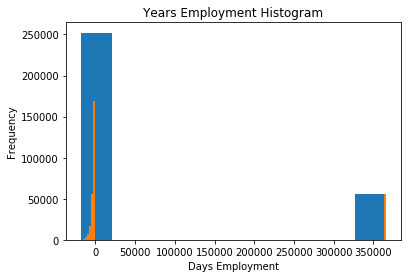

In [36]:
# Plot DAYS_EMPLOYED per years
train['DAYS_EMPLOYED'].plot.hist(title = 'Years Employment Histogram')
plt.xlabel('Days Employment')

# The plot shows a clearly bipartite distribution. Call anomalies the ones around 1k years and healthy the ones around 0
# Increase now the number of bits to actually see if such a distribution has bigger granularity
train['DAYS_EMPLOYED'].plot.hist(title = 'Years Employment Histogram', bins=150)
plt.xlabel('Days Employment')

In [37]:
# The previous plot gives us an insight: the anomalies appear to have all exactly 1k years of employment, lets check it analitically
anomalies = train[train['DAYS_EMPLOYED'] == 365243]
healthy = train[(train['DAYS_EMPLOYED'] >= -17912) & (train['DAYS_EMPLOYED'] <= 0)]
print("Number of anomalies with 1k years of work: %d" % len(anomalies))
print("Number of healty records: %d" % len(healthy))
print("Is there anyone missing?: %d" % (307511 - (len(healthy)+len(anomalies))) )

Number of anomalies with 1k years of work: 55374
Number of healty records: 252137
Is there anyone missing?: 0


In [38]:
#Once we have understood that all the anomalies lie in exactly the same outlier, we want to see if they also have some correlation with the ratio of defaults
print('The non-anomalies default on %0.2f%% of loans' % (100 * healthy['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anomalies['TARGET'].mean()))
#With respect to the default-ratio of the healthy, the anomalies have a lower default rate.

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans


In [39]:
#Therefore it seems like there is some correlation between the loans that was wrongly recorded (employment - wise) and the rate of defaults. Like they encode hidden feature/s. We then might want to tell this to the classifier by explicitly making a new "employment-anomaly" feature. However, we also don't want to loose the idea of days of employment. That's why we will set a new common value to all the anomalies, such as the median of the healthy.

#Create an anomalous boolean flag column
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243
#Label it w/ 0 1
le = sklearn.preprocessing.LabelEncoder()
train['DAYS_EMPLOYED_ANOM']=le.fit_transform(train['DAYS_EMPLOYED_ANOM'])

#Replace the anomalous values with median
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
train['DAYS_EMPLOYED'].fillna(train['DAYS_EMPLOYED'].median(), inplace=True)

#Note that the test follow the same distribution between anomaly and healthy DAYS_EMPLOYMENT. Therefore to the same processing to it
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243

le = sklearn.preprocessing.LabelEncoder()
test['DAYS_EMPLOYED_ANOM']=le.fit_transform(test['DAYS_EMPLOYED_ANOM'])

test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
test['DAYS_EMPLOYED'].fillna(test['DAYS_EMPLOYED'].median(), inplace=True)

In [40]:
train['DAYS_EMPLOYED_ANOM'].describe()

count    307511.000000
mean          0.180072
std           0.384248
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: DAYS_EMPLOYED_ANOM, dtype: float64

In [41]:
# Take a look at the remaining columns to see if there are any salient feature to be inspected for anomalies
from IPython.display import display
pd.options.display.max_columns = None
display(test.describe())


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,incomplete,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,DAYS_EMPLOYED_ANOM
count,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48744.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,48744.00000

In [42]:
# After and in-depth check of all the remaining features we did not find any substantial indication for anomalies. Plus, most of the remaining features are normalized hence difficult to interpret

In [43]:
## Bit of Feature Engineering ##
# Following the suggestion of several online notebooks, we opted to add simple features made from percentages of the easiset to interpret features
# Source: https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

train['DAYS_EMPLOYED_PERC'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
train['INCOME_CREDIT_PERC'] = train['AMT_INCOME_TOTAL'] / train['AMT_CREDIT']
train['INCOME_PER_PERSON'] = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']
train['ANNUITY_INCOME_PERC'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['PAYMENT_RATE'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']

test['DAYS_EMPLOYED_PERC'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
test['INCOME_CREDIT_PERC'] = test['AMT_INCOME_TOTAL'] / test['AMT_CREDIT']
test['INCOME_PER_PERSON'] = test['AMT_INCOME_TOTAL'] / test['CNT_FAM_MEMBERS']
test['ANNUITY_INCOME_PERC'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
test['PAYMENT_RATE'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']

In [44]:
# Save what is done so far
train.to_csv('../../datatmp/data/train.csv', index=False)
test.to_csv('../../datatmp/data/test.csv', index=False)

In [45]:
# Continue to the merge phase